In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



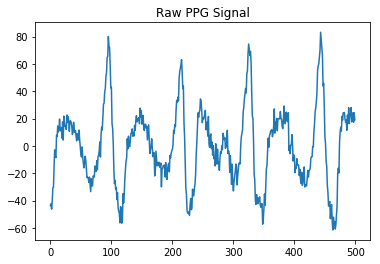

In [2]:
path = r"C:\Users\Adway\Desktop\Mini Project\Data File\MAX data"
dataset1 = pd.read_csv(r"C:\Users\Adway\Desktop\Mini Project\Data File\New Cleaned\Mini Project\S0021\SS0038.csv",) 
plt.title("Raw PPG Signal") 
dataset1 = dataset1.rename(columns = {'S2': 'PLETH'})
#dataset1 = dataset1[9000:len(dataset1)-1]
#dataset1 = dataset1.reset_index(drop = True)
#drop_locs = dataset1.loc[dataset1['PLETH'] == 2147483647].index
#dataset1 = dataset1.drop(drop_locs)
dataset = dataset1.PLETH
plt.plot(dataset) 
plt.show() 

In [3]:
dataset1.head()

,time,S1,PLETH,S3
0,0,-161.52,-43.651,-60.225
1,1,-147.21,-42.382,-52.004
2,2,-145.56,-46.295,-50.995
3,3,-122.61,-40.401,-54.216
4,4,-102.39,-30.712,-53.684


In [4]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import butter, filtfilt, welch, periodogram, resample_poly, resample, firwin

def highpass(data,f):
    '''Defines standard Butterworth lowpass filter.
    '''
    numtaps = 77
    filterc = firwin(numtaps, f)
    filtered =  np.array([np_convolve(xi, filterc , mode='valid') for xi in x])
    return filtered

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
measures = {}
def get_data(filename):
    data = pd.read_csv(filename)
    dataset1 = data.rename(columns = {'S2': 'PLETH'})
    dataset = dataset1.PLETH
    return dataset

In [6]:
def scale_data(dataset):
    '''Scales data between 0 and 1024 for analysis
    
    Keyword arguments:
    data -- numpy array or list to be scaled
    '''
    range = np.max(dataset) - np.min(dataset)
    minimum = np.min(dataset)
    dataset = 1024 * ((dataset - minimum) / range)
    plt.plot(dataset)
    plt.show()

In [7]:
def enhance_peaks(dataset, iterations=2):
    
    scale_data(dataset)
    for i in range(iterations):
        dataset = np.power(dataset, 2)
        dataset = scale_data(dataset)
    return dataset    

In [8]:
def movingavg(dataset, hrw, fs):
    mov_avg = dataset['PLETH'].rolling(int(hrw*fs)).mean()
    avg_hr = (np.mean(dataset.PLETH))
    mov_avg = [avg_hr if math.isnan(x) else x for x in mov_avg]
    #mov_avg = [x*1.15 for x in mov_avg]
    dataset['new_rollingmean'] = mov_avg

In [9]:
def detect_peaks(dataset):
    w = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.PLETH:
        rollingmean = dataset.new_rollingmean[listpos]
        if (datapoint <= rollingmean) and (len(w) <= 1):
            listpos += 1
        elif (datapoint > rollingmean):
            w.append(datapoint)
            listpos += 1
        else:
            maximum = max(w)
            beatposition = listpos - len(w) + (w.index(max(w)))
            peaklist.append(beatposition)
            w = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.PLETH[x] for x in peaklist]
    

In [10]:
# def calc_RR(dataset, fs):
#     RR_list = []
#     peaklist = measures['peaklist']
#     cnt = 0
#     while (cnt < (len(peaklist)-1)):
#         RR_interval = (peaklist[cnt+1] - peaklist[cnt])
#         ms_dist = ((RR_interval / fs) * 1000.0)
#         RR_list.append(ms_dist)
#         cnt += 1
    
#     RR_dif = []
#     RR_sqdif = []
#     cnt = 0
#     while (cnt < (len(RR_list)-1)):
#         RR_dif.append(abs(RR_list[cnt] - RR_list[cnt+1]))
#         RR_sqdif.append(math.pow(RR_dif[cnt] - RR_list[cnt+1], 2))
#         cnt += 1
#     measures['RR_list'] = RR_list
#     measures['Rdif'] = RR_dif
#     measures['Rsqdif'] = RR_sqdif

In [11]:
def calc_RR(peaklist, sample_rate, working_data={}):
    
    #peaklist = np.array(peaklist) #cast numpy array to be sure or correct array type

    #delete first peak if within first 150ms (signal might start mid-beat after peak)
    if len(peaklist) > 0:
        if peaklist[0] <= ((sample_rate / 1000.0) * 100):
            peaklist = np.delete(peaklist, 0)
            working_data['peaklist'] = peaklist
            working_data['ybeat'] = np.delete(working_data['ybeat'], 0)

    rr_list = (np.diff(peaklist) / sample_rate) * 1000.0
    rr_diff = np.abs(np.diff(rr_list))
    rr_sqdiff = np.power(rr_diff, 2)
    working_data['RR_list'] = rr_list
    working_data['Rdif'] = rr_diff
    working_data['Rsqdif'] = rr_sqdiff

In [12]:
def detect_peaks_new(dataset,ma_per,fs):
    rolmean = [(x+((x/100)*ma_per)) for x in dataset.new_rollingmean]
    w = []
    peaklist = []
    listpos = 0
    for datapoint in dataset.PLETH:
        rollingmean = dataset.new_rollingmean[listpos]
        if (datapoint <= rollingmean) and (len(w) <= 1):
            listpos += 1
        elif (datapoint > rollingmean):
            w.append(datapoint)
            listpos += 1
        else:
            maximum = max(w)
            beatposition = listpos - len(w) + (w.index(max(w)))
            peaklist.append(beatposition)
            w = []
            listpos += 1
    measures['peaklist'] = peaklist
    measures['ybeat'] = [dataset.PLETH[x] for x in peaklist]
    measures['rolmean'] = rolmean
    calc_RR(peaklist, fs, measures)
    measures['rrsd'] = np.std(measures['RR_list'])

In [13]:
def fit_peaks(dataset, fs):
    ma_perc_list = [5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 150, 200, 300] #List with moving average raise percentages, make as detailed as you like but keep an eye on speed
    rrsd = []
    valid_ma = []
    for x in ma_perc_list: #Detect peaks with all percentages, append results to list 'rrsd'
        detect_peaks_new(dataset, x, fs)
        bpm = ((len(measures['peaklist'])/(len(dataset.PLETH)/fs))*60)
        measures['bpm_2'] = bpm
        rrsd.append([measures['rrsd'], bpm, x])
    for x,y,z in rrsd: #Test list entries and select valid measures
        if ((x > 1) and ((y > 30) and (y < 130))):
            valid_ma.append([x, z])
    #measures['best'] = min(valid_ma, key = lambda t: t[0])[1] #Save the ma_perc for plotting purposes later on (not needed)
#     detect_peaks(dataset, min(valid_ma, key = lambda t: t[0])[1], fs)

In [14]:
def better_peaks():
    
    RR_list = measures['RR_list'] #Get measures
    peaklist = measures['peaklist']
    ybeat = measures['ybeat']
    upper_threshold = (np.mean(RR_list) + 180) #Set thresholds
    lower_threshold = (np.mean(RR_list) - 40)
    #detect outliers
    cnt = 0
    removed_beats = []
    removed_beats_y = []
    RR2 = []
    while cnt < len(RR_list):
        if (RR_list[cnt] < upper_threshold) and (RR_list[cnt] > lower_threshold):
            RR2.append(RR_list[cnt])
            cnt += 1
        else:
            removed_beats.append(peaklist[cnt])
            removed_beats_y.append(ybeat[cnt])
            cnt += 1
            
    measures['RR_list_new'] = RR2
    measures['removed_peaks'] = removed_beats
    #newpeak = list(set(peaklist)-set(removed_beats))
    newpeak = [i for i in peaklist + removed_beats if i not in peaklist or i not in removed_beats]
    #newpeak1 = newpeak.sort()
    measures['new_peaklist'] = newpeak
    #newpeak_y = list(set(ybeat)-set(removed_beats_y))
    #newpeak_y1 = newpeak_y.sort()
    newpeak_y = [i for i in ybeat + removed_beats_y if i not in ybeat or i not in removed_beats_y]
    measures['newpeaks_y'] = newpeak_y
    plt.subplot(211)
    plt.title('Marked Uncertain Peaks')
    plt.plot(dataset1.PLETH, color='blue', alpha=0.6, label='heart rate signal')
    plt.plot(measures['rolmean'], color='green')
    plt.scatter(measures['peaklist'], measures['ybeat'], color='green')
    plt.scatter(removed_beats, removed_beats_y, color='red', label='Detection uncertain')
    plt.legend(framealpha=0.6, loc=4)
    plt.subplot(212)
    plt.title("RR-intervals with thresholds")
    plt.plot(RR_list)
    plt.axhline(y=upper_threshold, color='red')
    plt.axhline(y=lower_threshold, color='red')
    plt.show()

In [15]:
def calc_bpm(dataset):
    RR_list1 = measures['RR_list']
    measures['bpm'] = 60000 / np.mean(RR_list1)
    #measures['bpm'] = (100/np.mean(RR_list_new))*60

In [16]:
def plotter(dataset, title):
    peaklist = measures['new_peaklist']
    ybeat = measures['newpeaks_y']
    
#     l1 = len( measures['new_peaklist'])
#     l2 = len(measures['newpeaks_y'])
#     if l2 < l1:
#         peaklist = measures['new_peaklist'][0:l2]
    
    
    plt.title(title)
    plt.plot(dataset.PLETH, alpha=0.5, color='blue', label="raw signal")
    plt.plot(dataset.new_rollingmean, color ='green', label="moving average")
    plt.scatter(peaklist, ybeat, color='red', label="average: %.1f BPM" %measures['bpm'])
    plt.legend(loc=4, framealpha=0.6)
    plt.show()
    

In [17]:
def time_measures():
    RR_list = measures['RR_list']
    RR_diff = measures['Rdif']
    RR_sqdiff = measures['Rsqdif']
    measures['bpm'] = 60000 / np.mean(RR_list)
    measures['ibi'] = np.mean(RR_list)
    measures['sdnn'] = np.std(RR_list)
    measures['sdsd'] = np.std(RR_diff)
    measures['rmssd'] = np.sqrt(np.mean(RR_sqdiff))
    NN20 = [x for x in RR_diff if (x>20)]
    NN50 = [x for x in RR_diff if (x>50)]
    measures['nn20'] = NN20
    measures['nn50'] = NN50
    measures['pnn20'] = float(len(NN20)) / float(len(RR_diff))
    measures['pnn50'] = float(len(NN50)) / float(len(RR_diff))

In [18]:
def process(dataset, hrw, fs): 
    
    #enhance_peaks(dataset)
    movingavg(dataset, hrw, fs)
    detect_peaks(dataset)
    detect_peaks_new(dataset,30,fs)
    fit_peaks(dataset,fs)
    better_peaks()
    scale_data(dataset)
    calc_RR(measures['new_peaklist'], fs, working_data = measures)
    calc_bpm(dataset)
    time_measures()
    plotter(dataset, "Your PPG Plot  with peaks")


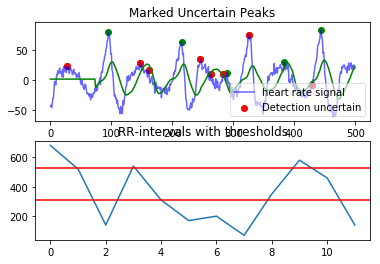

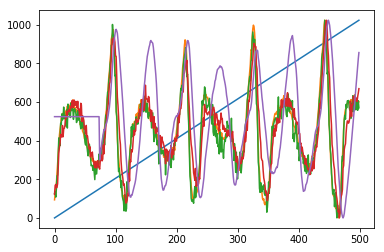

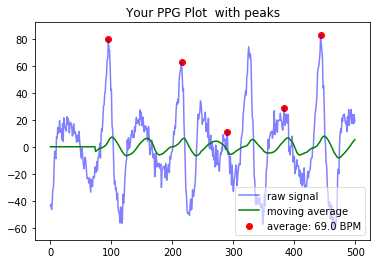

In [19]:
process(dataset1,0.75,100)


In [20]:
print(len(measures['new_peaklist']))
print(len(measures['newpeaks_y']))

5
5


In [21]:
from scipy.interpolate import interp1d #Import the interpolate function from SciPy
peaklist = measures['new_peaklist'] 
RR_list = measures['RR_list']
RR_x = peaklist[1:] 
RR_y = RR_list 
RR_x_new = np.linspace(RR_x[0],RR_x[-1],RR_x[-1]) #Create evenly spaced timeline starting at the second peak, its endpoint and length equal to position of last peak
f = interp1d(RR_x, RR_y, kind='cubic') #Interpolate the signal with cubic spline interpolation

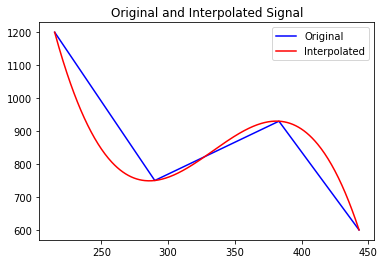

In [22]:
plt.title("Original and Interpolated Signal")
plt.plot(RR_x, RR_y, label="Original", color='blue')
plt.plot(RR_x_new, f(RR_x_new), label="Interpolated", color='red')
plt.legend()
plt.show()

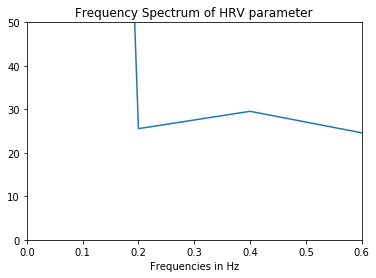

In [23]:
#Set variables
fs = 100
n = len(dataset1.PLETH) #Length of the signal
frq = np.fft.fftfreq(len(dataset1.PLETH), d=((1/fs))) #divide the bins into frequency categories
frq = frq[range(n//2)] 
#Do FFT
Y = np.fft.fft(f(RR_x_new))/n #Calculate FFT
Y = Y[range(n//2)] #Return one side of the FFT
#Plot
plt.title("Frequency Spectrum of HRV parameter")
plt.xlim(0,0.6) #Limit X axis to frequencies of interest (0-0.6Hz for visibility, we are interested in 0.04-0.5)
plt.ylim(0, 50) #Limit Y axis for visibility
plt.plot(frq, abs(Y)) #Plot it
plt.xlabel("Frequencies in Hz")
plt.show()

In [24]:
lf = np.trapz(abs(Y[(frq>=0.04) & (frq<=0.15)])) #Slice frequency spectrum where x is between 0.04 and 0.15Hz (LF), and use NumPy's trapezoidal integration function to find the area
print("LF:", lf)
hf = np.trapz(abs(Y[(frq>=0.16) & (frq<=0.5)])) #Do the same for 0.16-0.5Hz (HF)
print("HF:", hf)

measures['LF'] = lf
measures['HF'] = hf
measures

LF: 0.0
HF: 27.55169285007853


{'peaklist': [27, 95, 147, 161, 215, 246, 263, 283, 290, 325, 383, 429, 443],
 'ybeat': [22.584,
  80.04,
  27.643,
  15.421,
  63.071000000000005,
  34.356,
  8.7531,
  9.2124,
  11.402000000000001,
  74.525,
  29.197,
  -8.0081,
  83.135],
 'rolmean': [1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,
  1.0612746176000016,

In [25]:
import csv
import os



with open('output.csv', 'a') as outputfile:
    writer = csv.writer(outputfile)
    writer.writerow(['bpm', 'ibi', 'sdnn', 'sdsd', 'rmssd', 'pnn20' , 'pnn50', 'LF', 'HF'],
                   ['measures['bpm']','measures['ibi']', 'measures['sdnn']', 'measures['sdsd']', 'measures['rmssd']', 'measures['pnn20']' , 'measures['pnn50']', 'measures['LF']', 'measures['HF']' ])

SyntaxError: invalid syntax (<ipython-input-25-207a7f9539fa>, line 9)

In [ ]:
peaklist': [12,
  26,
  53,
  79,
  93,
  99,
  121,
  154,
  165,
  189,
  217,
  232,
  242,
  255,
  289,
  307,
  322,
  354,
  369,
  373,
  377,
  391,
  425,
  440,
  457,
  487],
 'ybeat': [13.657,
  10.564,
  87.73299999999999,
  32.367,
  11.164000000000001,
  6.0535,
  79.52600000000001,
  16.433,
  7.0372,
  79.97399999999999,
  27.592,
  -4.1221,
  -5.8486,
  77.336,
  25.598000000000003,
  13.574000000000002,
  88.015,
  21.968000000000004,
  1.5454,
  -2.3835,
  9.022,
  88.277,
  23.179000000000002,
  7.3375,
  75.643,
  25.859],
    
    new_peaklist': [26, 53, 99, 121, 165, 189, 255, 289, 322, 391, 457, 487],
 'newpeaks_y': [6.0535,
  7.0372,
  10.564,
  75.643,
  77.336,
  79.52600000000001,
  79.97399999999999,
  87.73299999999999,
  88.015,
  25.598000000000003,
  88.277,
  25.859],